# Example usage of a (skeleton for a) diffable HEP library

In [2]:
import jax
import jax.numpy as jnp

import numpy as np

import pyhf
# use jax backend of pyhf
pyhf.set_backend(pyhf.tensor.jax_backend())

import smooth
import smooth.infer

## Implementing Alex's differentiable cut example, using full pyhf:

In [3]:
nBg  = 8000
nSig = 300

background = np.random.normal(40, 10, nBg)
signal = np.random.normal(50, 5, nSig)

def generate_data():
    return signal, background

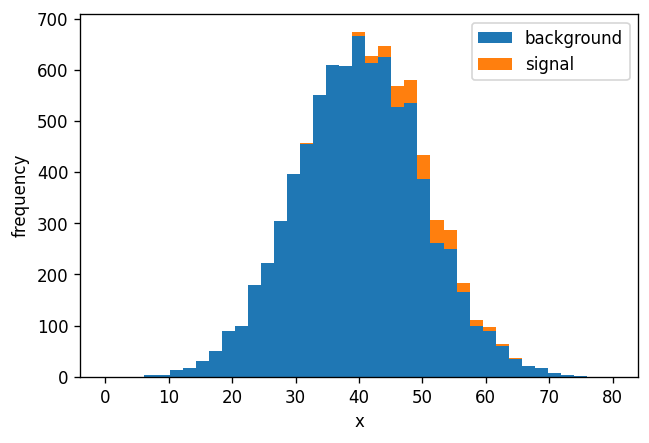

In [4]:
import matplotlib.pyplot as plt

bins = np.linspace(0, 80, 40)
plt.figure(dpi=120)
ax = plt.gca()
plt.hist([background, signal], bins=bins, stacked=True, label=["background", "signal"])
ax.set(ylabel='frequency',xlabel='x')
plt.legend();

In [5]:
def preprocess(data_generator):
    
    def counts(cut_param):
        s, b = data_generator()
        
        s_counts = smooth.cut(s,'>',cut_param).sum()
        b_counts = smooth.cut(b,'>',cut_param).sum()
        
        return jnp.array([s_counts]), jnp.array([b_counts])
    
    return counts

In [6]:
def simple_histosys(data_with_cuts, uncert):
    """
    Makes a histosys model with up/down yields of +- bkg*(uncert/2).
    """

    def from_spec(yields):

        s, b = yields
        bup, bdown = b * (1 + (uncert / 2)), b * (1 - (uncert / 2))

        spec = {
            "channels": [
                {
                    "name": "smoothcut",
                    "samples": [
                        {
                            "name": "signal",
                            "data": s,
                            "modifiers": [
                                {"name": "mu", "type": "normfactor", "data": None}
                            ],
                        },
                        {
                            "name": "bkg",
                            "data": b,
                            "modifiers": [
                                {
                                    "name": "artificial_histosys",
                                    "type": "histosys",
                                    "data": {"lo_data": bdown, "hi_data": bup,},
                                }
                            ],
                        },
                    ],
                },
            ],
        }

        return pyhf.Model(spec)

    def model_maker(cut_pars):
        s, b = data_with_cuts(cut_pars)

        # make statistical model with pyhf
        m = from_spec([s, b])

        nompars = m.config.suggested_init()
        bonlypars = jnp.asarray([x for x in nompars])
        bonlypars = jax.ops.index_update(bonlypars, m.config.poi_index, 0.0)
        return m, bonlypars

    return model_maker

In [7]:
data_with_cuts = preprocess(generate_data)
model_maker    = simple_histosys(data_with_cuts, uncert=0.05)
loss           = smooth.infer.expected_pvalue_upper_limit(model_maker,
                                                          solver_kwargs=dict(pdf_transform=True))

jax.value_and_grad(loss)(1.,40.)

(DeviceArray(0.0068958, dtype=float64),
 DeviceArray(-0.04726333, dtype=float64))

### (Can then do gradient descent etc! I've left that out here.)

## Reimplementing neos:

In [8]:
def blobs(NMC=500, sig_mean = [-1, 1], b1_mean=[2.5, 2], b_mean=[1, -1], b2_mean=[-2.5, -1.5]):
    
    def generate_blobs():
        bkg_up = np.random.multivariate_normal(b1_mean, [[1, 0], [0, 1]], size=(NMC,))
        bkg_down = np.random.multivariate_normal(b2_mean, [[1, 0], [0, 1]], size=(NMC,))
        bkg_nom = np.random.multivariate_normal(b_mean, [[1, 0], [0, 1]], size=(NMC,))
        sig = np.random.multivariate_normal(sig_mean, [[1, 0], [0, 1]], size=(NMC,))
        
        return sig, bkg_nom, bkg_up, bkg_down
    
    return generate_blobs

In [9]:
def hists(data_generator, predict, bins, bandwidth, LUMI=10, sig_scale = 2, bkg_scale = 10):
    
    def hist_maker(nn):
        s, b_nom, b_up, b_down = data_generator()
        NMC = len(s)
        
        nn_s, nn_b_nom, nn_b_up, nn_b_down = (
            predict(nn, s).ravel(),
            predict(nn, b_nom).ravel(),
            predict(nn, b_up).ravel(),
            predict(nn, b_down).ravel(),
        )
             
        kde_counts = jax.numpy.asarray([
            smooth.hist(nn_s, bins, bandwidth) * sig_scale / NMC * LUMI,
            smooth.hist(nn_b_nom, bins, bandwidth) * bkg_scale / NMC * LUMI,
            smooth.hist(nn_b_up, bins, bandwidth) * bkg_scale / NMC * LUMI,
            smooth.hist(nn_b_down, bins, bandwidth) * bkg_scale / NMC * LUMI,
        ])
        
        return kde_counts
    
    return hist_maker

In [10]:
def nn_histosys(histogram_maker):
    
    def from_spec(yields):
        
        s, b, bup, bdown = yields
        
        spec = {
            "channels": [
                {
                    "name": "nn",
                    "samples": [
                        {
                            "name": "signal",
                            "data": s,
                            "modifiers": [
                                {"name": "mu", "type": "normfactor", "data": None}
                            ],
                        },
                        {
                            "name": "bkg",
                            "data": b,
                            "modifiers": [
                                {
                                    "name": "nn_histosys",
                                    "type": "histosys",
                                    "data": {
                                        "lo_data": bdown,
                                        "hi_data": bup,
                                    },
                                }
                            ],
                        },      
                    ],
                },
            ],
        }

        return pyhf.Model(spec)
    
    def nn_model_maker(nn):
        yields = histogram_maker(nn)
        m = from_spec(yields)
        nompars = m.config.suggested_init()
        bonlypars = jax.numpy.asarray([x for x in nompars])
        bonlypars = jax.ops.index_update(bonlypars, m.config.poi_index, 0.0)
        return m, bonlypars
    
    return nn_model_maker

In [11]:
import jax.experimental.stax as stax

# regression net
init_random_params, predict = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid
)

# choose hyperparams
bins = np.linspace(0,1,4)
centers   = bins[:-1]  + np.diff(bins)/2.
bandwidth = 0.8 * 1/(len(bins)-1)

# compose functions to define workflow
data   = blobs()
hmaker = hists(data,predict,bins=bins,bandwidth=bandwidth)
model  = nn_histosys(hmaker)
loss   = smooth.infer.expected_pvalue_upper_limit(model, solver_kwargs=dict(pdf_transform=True))


_, network = init_random_params(jax.random.PRNGKey(13), (-1, 2))
jax.value_and_grad(loss, argnums=1)(1.0, network)

(DeviceArray(0.03418747, dtype=float64),
 [(DeviceArray([[-6.4622873e-05, -5.2814426e-05,  1.9162399e-05, ...,
                 -2.6265348e-05,  5.9893882e-05, -4.1098698e-05],
                [ 1.0831091e-04,  1.7545686e-05, -8.0756972e-06, ...,
                  4.9211412e-06, -8.9975663e-05, -8.1753815e-06]],            dtype=float32),
   DeviceArray([-3.9383969e-05, -2.2616345e-05, -1.9260973e-05, ...,
                 2.3206361e-05,  3.7671431e-05, -2.1765823e-05],            dtype=float32)),
  (),
  (DeviceArray([[-6.9934777e-07,  5.7010297e-08,  3.8109571e-10, ...,
                 -1.0024851e-07,  1.5208009e-06,  6.4182098e-07],
                [ 1.8532944e-07,  2.2956806e-07,  2.6408258e-09, ...,
                  0.0000000e+00,  1.3109189e-07,  3.0246827e-10],
                [-3.6879607e-07, -7.7659470e-09, -2.6789959e-11, ...,
                  5.3488378e-09, -4.9338769e-07,  4.1606350e-07],
                ...,
                [-2.7106398e-07, -1.2677656e-06, -1.5544863e-0

In [12]:
import jax.experimental.optimizers as optimizers
import time

opt_init, opt_update, opt_params = optimizers.adam(1e-3)

def train_network(N):
    cls_vals = []
    _, network = init_random_params(jax.random.PRNGKey(1), (-1, 2))
    state = opt_init(network)
    losses = []
    
    # parameter update function
    def update_and_value(i, opt_state, mu):
        net = opt_params(opt_state)
        value, grad = jax.value_and_grad(loss,argnums=1)(mu, net)
        return opt_update(i, grad, state), value, net
    
    for i in range(N):
        start_time = time.time()
        state, value, network = update_and_value(i,state,1.0)
        epoch_time = time.time() - start_time
        losses.append(value)
        metrics = {"loss": losses}
        yield network, metrics, epoch_time

In [13]:

maxN = 10 # make me bigger for better results!

# Training
for i, (network, metrics, epoch_time) in enumerate(train_network(maxN)):
    print(f"epoch {i}:", f'p_mu = {metrics["loss"][-1]:.5f}, took {epoch_time:.2f}s')

epoch 0: p_mu = 0.03419, took 1.74s
epoch 1: p_mu = 0.01812, took 2.05s
epoch 2: p_mu = 0.00872, took 2.08s
epoch 3: p_mu = 0.00480, took 2.05s
epoch 4: p_mu = 0.00299, took 2.10s
epoch 5: p_mu = 0.00207, took 2.09s
epoch 6: p_mu = 0.00156, took 2.11s
epoch 7: p_mu = 0.00131, took 2.07s
epoch 8: p_mu = 0.00119, took 2.04s
epoch 9: p_mu = 0.00097, took 2.13s
